In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [2]:
df0 = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)

In [3]:
df0.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [4]:
df = df0[df0['Name'] == 'IBM'][['Close']].copy()

In [5]:
df['LogClose'] = np.log(df['Close'])

In [6]:
df['DiffLogClose'] = df['LogClose'].diff()

In [8]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [47]:
# Make supervised dataset
# Let's see if we can use T past values to predict the next value

series = df['DiffLogClose'].to_numpy()[1:]

T = 21 # number of lags
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2252, 10) Y.shape (2252,)


In [48]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [49]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.005398312779083314

In [50]:
lr.score(Xtest, Ytest)

-0.10929913512457667

In [51]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False

In [52]:
# Needed to compute un-differencing predictions
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

In [53]:
# Last-known train value
last_train = train.iloc[-1]['LogClose']

In [54]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

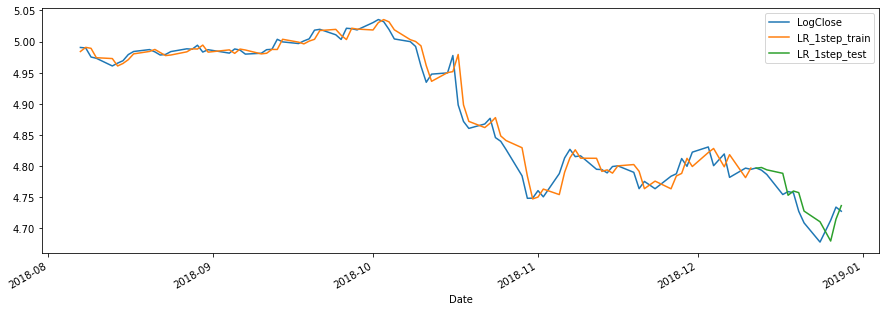

In [55]:
# plot 1-step forecast
cols = ['LogClose', 'LR_1step_train', 'LR_1step_test']
df.iloc[-100:][cols].plot(figsize=(15,5));

In [56]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = lr.predict(last_x.reshape(1,-1))[0]

    # update the predictions list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [57]:
# save multistep forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

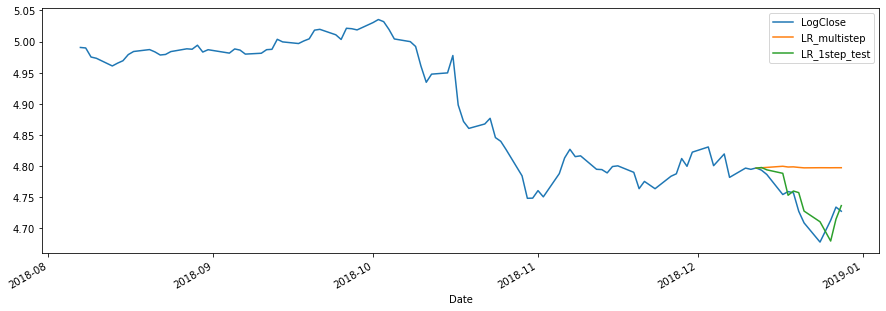

In [58]:
cols = ['LogClose', 'LR_multistep', 'LR_1step_test']
df.iloc[-100:][cols].plot(figsize=(15,5));

In [26]:
# make multi-output supervised dataset
Tx = T # number of step in the input
Ty = Ntest # number of steps in the output
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2230, 21) Y.shape (2230, 12)


In [27]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [28]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.010010133087045394

In [30]:
r2_score(lr.predict(Xtest_m).flatten(),Ytest_m.flatten())

-489.94938006136147

In [31]:
# save multi-output forecast to datagrame
df.loc[test_idx, 'LR_multioutput'] = last_train + \
    np.cumsum(lr.predict(Xtest_m).flatten())

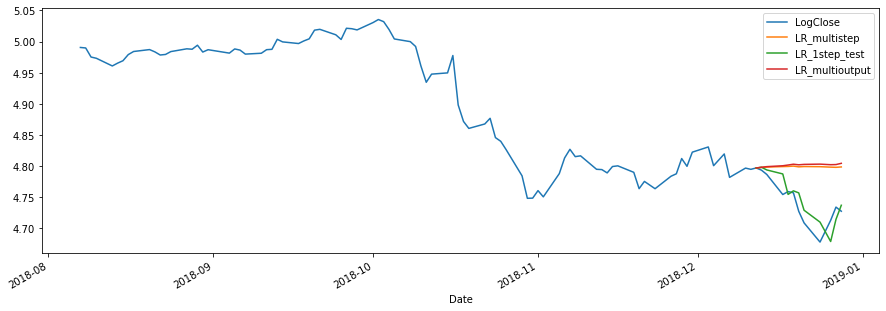

In [35]:
# plot all forecasts
cols = ['LogClose', 'LR_multistep',
        'LR_1step_test', 'LR_multioutput']
df.iloc[-100:][cols].plot(figsize=(15,5));

In [36]:
# MAPE
test_log_loss = df.iloc[-Ntest:]['LogClose']
mape1 = mean_absolute_percentage_error(test_log_loss, df.loc[test_idx, 'LR_multistep'])
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(test_log_loss, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.011426326090850475
multi-output MAPE: 0.011998190671272004


In [39]:
def one_step_and_multistep_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    print("One-step forecast:", name)

    # store l-step forecast
    df.loc[train_idx, f'{name}_1step_train'] = prev[train_idx] + model.predict(Xtrain)
    df.loc[test_idx, f'{name}_1step_test'] = prev[test_idx] + model.predict(Xtest)

    # generate multi-step forecast
    multistep_predictions = []

    # first test input
    last_x = Xtest[0]

    while len(multistep_predictions) < Ntest:
        p = model.predict(last_x.reshape(1,-1))[0]

        # update the predictions list
        multistep_predictions.append(p)

        # make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p

    # store multi-strp forecast
    df.loc[test_idx, f'{name}_multistep_test'] = last_train + np.cumsum(multistep_predictions)

    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(test_log_loss,
                                          df.loc[test_idx, f'{name}_multistep_test'])
    print("Test MAPE (multi-step):", mape)

    # plot 1-step and multi-step forecast
    cols = [
        'LogClose',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test'
    ]
    df.iloc[-100:][cols].plot(figsize=(15,5));

One-step forecast: SVR
Test MAPE (multi-step): 0.009692971150318556


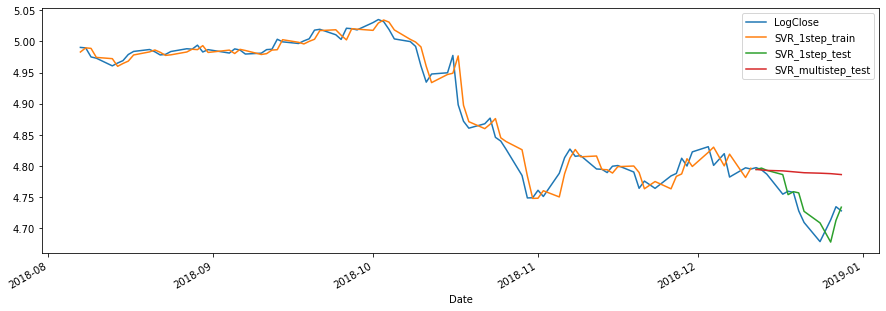

In [40]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.014528268789571917


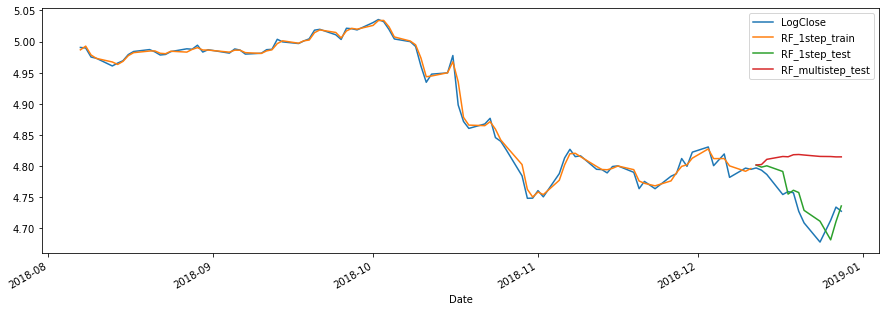

In [41]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [42]:
def multi_output_forecast(model, name):
    model.fit(Xtrain_m, Ytrain_m)

    # save multi-output forecast to dataframe
    df.loc[test_idx, f'{name}_multioutput'] = \
        last_train + np.cumsum(model.predict(Xtest_m).flatten())

    mape = mean_absolute_percentage_error(
        test_log_loss, df.loc[test_idx, f'{name}_multioutput']
    )
    print("Test MAPE (multi-output):", mape)

    # plot all forecasts
    # assume that previous functions have been run
    cols = [
        'LogClose',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test',
        f'{name}_multioutput'
    ]
    df.iloc[-100:][cols].plot(figsize=(15,5));

In [44]:
class SVRWrapper:
    def __init__(self, h, **args):
        self.h = h
        self.models = [SVR(**args) for _ in range(h)]

    def fit(self, X, Y):
        for k in range(self.h):
            self.models[k].fit(X, Y[:, k])

    def predict(self, X):
        P = [m.predict(X) for m in self.models]
        return np.hstack(P)

Test MAPE (multi-output): 0.009692971150318556


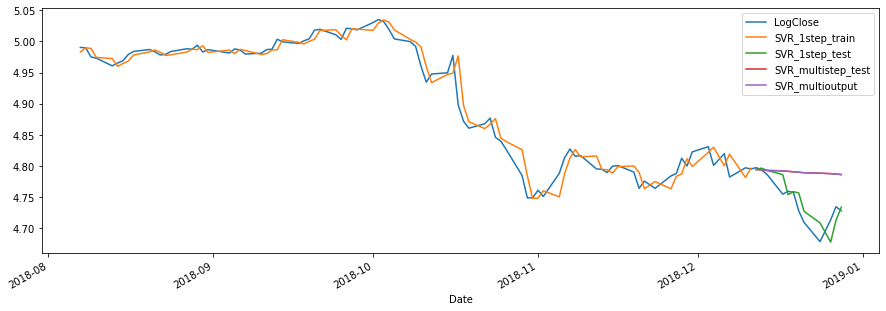

In [45]:
multi_output_forecast(SVRWrapper(Ntest), "SVR")

Test MAPE (multi-output): 0.011484609332129206


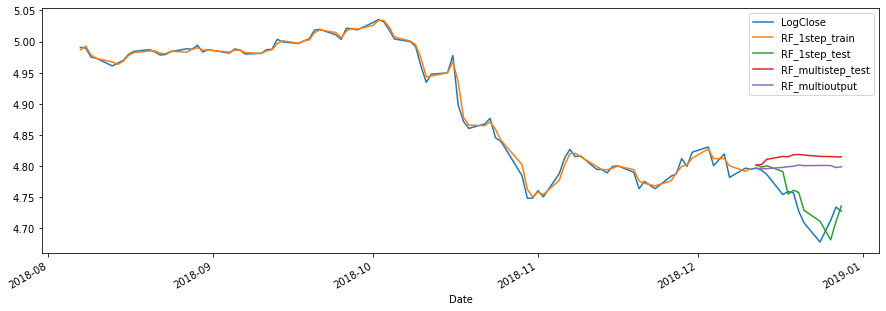

In [46]:
multi_output_forecast(RandomForestRegressor(), "RF")